In [1]:
import numpy as np

In [3]:
from matplotlib import pyplot

In [24]:
def solve_2nd_degree(a, b, c): 
    delta = b ** 2 - 4 * a * c
    if delta < 0: 
        raise ValueError("no solution")
    return (
        (-b + np.sqrt(delta)) / (2 * a),
        (-b - np.sqrt(delta)) / (2 * a)
    )


In [33]:
# test 

a, b, c = 1.3, -4.5, 2.7
for x in solve_2nd_degree(a, b, c): 
    np.testing.assert_almost_equal(a * x ** 2 + b * x + c, 0)


In [30]:
def solve_2_constrained(alpha, beta, gamma):
    """ 
    solve alpha * c + beta * s = gamma
    st c^2 + s^2 = 1
    """
    # numerical stability 
    # if abs(beta) > abs(alpha): 
    s0, s1 = solve_2nd_degree(
        alpha ** 2 + beta ** 2, 
        - 2 * gamma * beta, 
        gamma ** 2 - alpha ** 2        
    )
    return [
        ((gamma - beta * s) / alpha, s)
        for s in (s0, s1)
    ]
    

In [47]:
alpha, beta, gamma = 1.3, -4.5, 2.7
# alpha, beta, gamma = 0.921071118888964, 0.3688887849709659, 0.3159564210598485
for c, s in solve_2_constrained(alpha, beta, gamma): 
    np.testing.assert_almost_equal(alpha * c + beta * s, gamma)
    np.testing.assert_almost_equal(c ** 2 + s ** 2, 1.0)


In [64]:

def solve_4x3_constrained(A, b): 
    """ 
    Solve A * x = b
    with A 4*3 and the constraint that x[2] ** 2 + x[3] ** 2 = 1
    """
    A1 = A[:, :2]
    A2 = A[:, 2:]    
    Q, R = np.linalg.qr(A1, mode='complete')
    # print(R)
    # print(Q)
    
    Qb = Q.T @ b.reshape(3, 1)
    QA = Q.T @ A2
    alpha, beta = QA[2]
    gamma = Qb[2, 0]
    # print(alpha, beta, gamma)
    
    res = []
    for c, s in solve_2_constrained(alpha, beta, gamma): 
        q3 = (Q.T @ (b.reshape(3, 1) - A2 @ np.array([[c], [s]])))
        xc, yc = np.linalg.solve(R[:2], q3[:2]).ravel()
        res.append(np.array((xc, yc, c, s)))
    return res

In [90]:
rs = np.random.RandomState(1233)
A = rs.normal(size=(3, 4))
b = rs.normal(size=3)

for xx in solve_4x3_constrained(A, b): 
    np.testing.assert_array_almost_equal(
        (A @ xx.reshape(4, 1)).ravel(), b)
    np.testing.assert_almost_equal(xx[2] ** 2 + xx[3] ** 2, 1)

In [106]:
def find_transfo_3pt_line(points, segs): 
    """ 
    Find rigid transformation that maps a0 to segment (b0, c0), a1 to (b1, c1) etc.
    parameterization of transofrmation: 
    t([x, y]) = [xc, yc]' + [c, s;-s, c] * [x, y]'
    """
    # eq is A * [xc, yc, c, s]' = B
    A = np.zeros((3, 4))
    B = np.zeros(3)
    i = 0
    for p, (q, r) in zip(points, segs): 
        # eq of segment: a.z = b
        a = np.array((q[1] - r[1], r[0] - q[0]))
        b = np.dot(a, q)
        # 
        A[i, :2] = a
        A[i, 2] =  a[0] * p[0] + a[1] * p[1]
        A[i, 3] = -a[0] * p[1] + a[1] * p[0]
        B[i] = b
        i += 1
    
    return solve_4x3_constrained(A, B)


In [108]:
rs = np.random.RandomState(1283)

points = rs.randn(3, 2)
segs = rs.randn(3, 2, 2)

for xc, yc, c, s in find_transfo_3pt_line(points, segs): 
    for i in range(3): 
        x, y = points[i]
        q, r = segs[i]
        a = np.array((q[1] - r[1], r[0] - q[0]))
        b = np.dot(a, q)
        pt = np.array([
           xc + c * x - s * y, 
           yc + s * x + c * y           
        ])
        np.testing.assert_almost_equal(np.dot(pt, a), b)



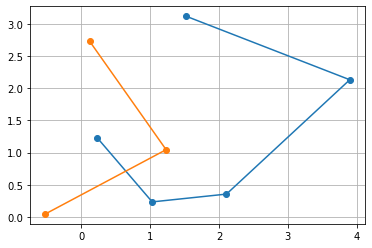

In [113]:
A = np.array([
    (0.23, 1.232), 
    (1.03, 0.2323), 
    (2.109, 0.354), 
    (3.9, 2.13434), 
    (1.523, 3.1233)   
])

B = np.array([
    (-0.5212, 0.0452334), 
    (1.232, 1.04545), 
    (0.12221, 2.732)   
])

pyplot.plot(A[:, 0], A[:, 1], 'o-') 
pyplot.plot(B[:, 0], B[:, 1], 'o-') 
pyplot.grid()

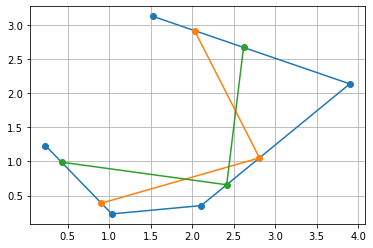

In [114]:
res = find_transfo_3pt_line(
    B, 
    [
        (A[0], A[1]), 
        (A[2], A[3]), 
        (A[3], A[4])
    ]
)

pyplot.plot(A[:, 0], A[:, 1], 'o-') 

for xc, yc, c, s in res: 
    Bt = np.array([
        (xc + c * x - s * y, yc + s * x + c * y)
        for x, y in B        
    ])
    pyplot.plot(Bt[:, 0], Bt[:, 1], 'o-') 

pyplot.grid()
